# Processing µCT images with python
<font size="4">
<br>
$ \text{The tutorial given below can be used for segmentation of 3-D tomography images}$

https://scikit-image.org/
    
</font> 

## Loading libraries 

In [5]:
%matplotlib notebook
from skimage import io
import numpy as np
from skimage import img_as_float, img_as_ubyte
from matplotlib import pyplot as plt
import scipy.ndimage as ndi
from skimage import filters
from skimage.morphology import disk
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
from skimage.segmentation import random_walker
from skimage import data_dir
from skimage import (filters, exposure, feature, segmentation, morphology, img_as_float,restoration)
from dask import delayed
from skimage.restoration import denoise_nl_means
from time import time
from skimage import util
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

## Loading the images

<font size="4">
If the stack is already constructed
    
***
`
    Stack=io.imread('./name of the file.tif')
`
***
</font>

In [8]:
%%time
Images=io.ImageCollection('G:/09-30/e50cb_60tr_18_09_1µm/e50cb_60tr_18_09_1µm/*.tif')# location of the image files
Stack_3d=io.concatenate_images(Images) # to define the image stack as array: stack_3D(z,y,x)

Wall time: 2.96 s


In [38]:
stack_3d=Stack_3d[200:300,200:600,200:600]#stack_3D(z,y,x), reducing the size of the stack for the analysis

## Methodology
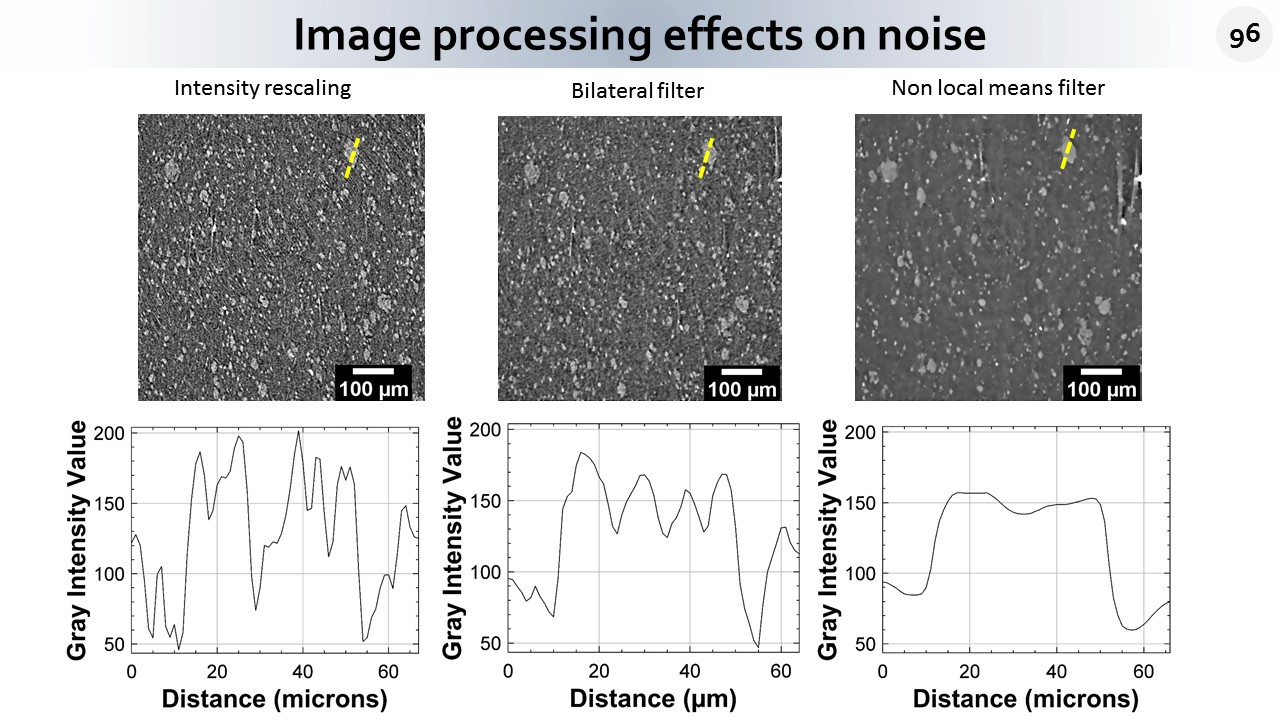

## Intensity Rescaling 
<br>
<font size="4">
Most of the times the contrast of the image will not be adequate.Algorithms in  require floating-point images to have values between 0 and 1. Therefore, we first rescale the range of values. Before rescaling, we saturate the extreme (dark and light) 0.4% of gray values. These extreme values can be due to experimental noise and saturating them will result in a better contrast.<br/>
 </font>

In [39]:
from scipy import stats
vmin, vmax = stats.scoreatpercentile(stack_3d, (0.4, 99.4))# saturate the darkest and lightest 0.4% of gray values
Stack = np.clip(stack_3d, vmin, vmax)
Stack = (Stack - vmin) / (vmax - vmin) #rescale the range of values

<IPython.core.display.Javascript object>


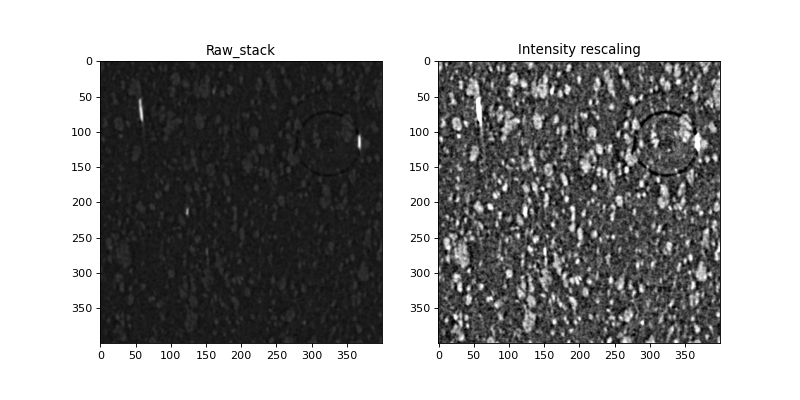

Text(0.5, 1.0, 'Intensity rescaling')

In [40]:
#to show the images
fig, ax =plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(Stack_3d[240,200:600,200:600], cmap='gray')
ax[1].imshow(Stack[40], cmap='gray',)
ax[0].set_title('Raw_stack')
ax[1].set_title('Intensity rescaling')

## Denoising filters: Median filter
<font size="4">
<br>
We will see what happens if you want to apply median filter

In [74]:
from skimage.filters.rank import median
from skimage.morphology import disk, ball
median=median(Stack, ball(3)) ## Here we are using a distance of 3 pixel for median filter

C:\Anaconda3-5.1.0\envs\jesbeer\lib\site-packages\skimage\filters\rank\generic.py:279: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


## Denoising filters: Bilateral filter

<br>
<font size="4">
$ \text{Before segmentation we apply a denoising filter to the image} \\ $
</font>


## Bilateral filter
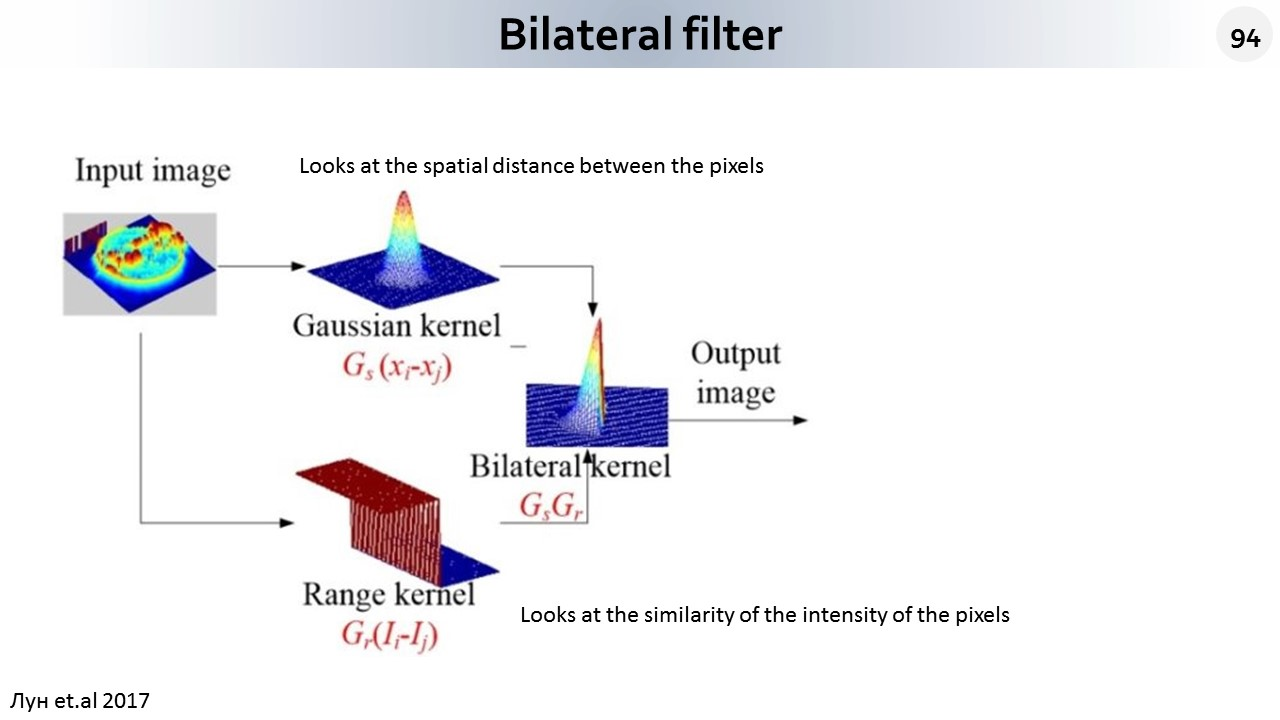

<br>
<font size="4">
    
**sigma_color=0.1** *# Range kernal* <br/>
**sigma_spatial=5** *# Gaussian kernal* <br/><br/>

In [41]:
%%time
from skimage import restoration
x=len(Stack)
bilateral=np.zeros((Stack.shape))# create a null matrix with shape of Stack. Bilateral filteral is only implement for 2D images
for i in range(x):
    bilateral[i,:,:]=  restoration.denoise_bilateral(Stack[i,:,:],sigma_color=0.1, sigma_spatial=5)

Wall time: 4min 13s


<IPython.core.display.Javascript object>


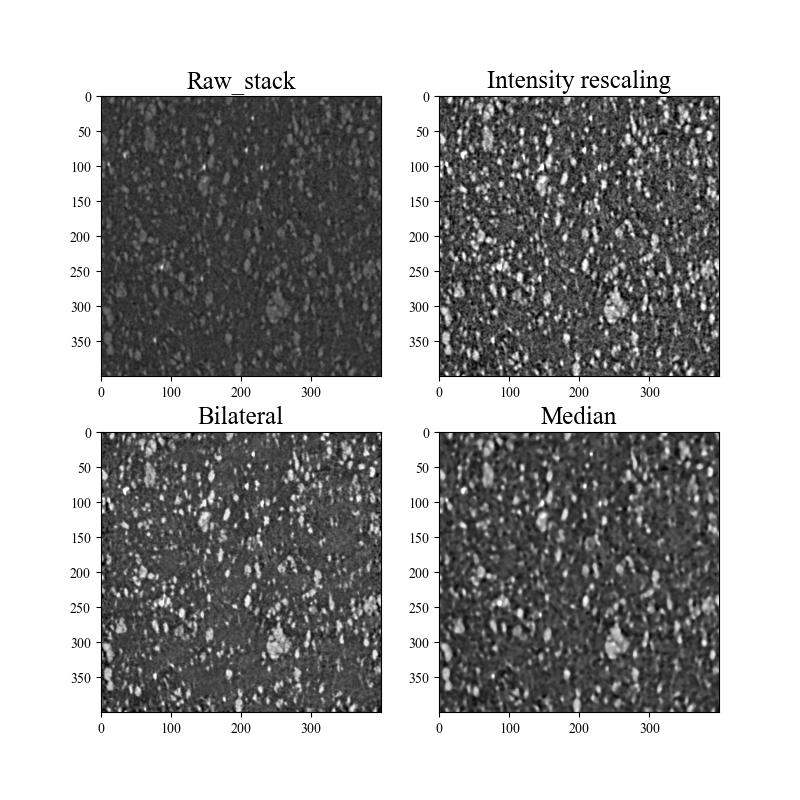

Text(0.5, 1.0, 'Median')

In [75]:
#to show the images
fig, ax =plt.subplots(2,2, figsize=(8,8))
ax[0,0].imshow(Stack_3d[210,200:600,200:600], cmap='gray')
ax[0,1].imshow(Stack[10], cmap='gray',)
ax[1,0].imshow(bilateral[10], cmap='gray',)
ax[1,1].imshow(median[10], cmap='gray',)
ax[0,0].set_title('Raw_stack',fontsize=18)
ax[0,1].set_title('Intensity rescaling',fontsize=18)
ax[1,0].set_title('Bilateral',fontsize=18)
ax[1,1].set_title('Median',fontsize=18)

<IPython.core.display.Javascript object>


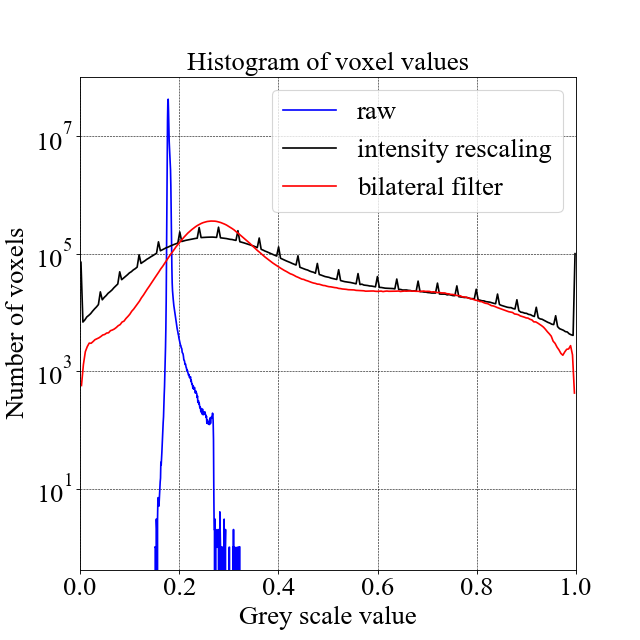

Text(0.5, 1.0, 'Histogram of voxel values')

In [62]:
from skimage import exposure
histogram_raw = exposure.histogram(img_as_float(Stack_3d[:,200:600,200:600]))# to get the histogram of grey scale values
histogram_Stack = exposure.histogram(Stack)# to get the histogram of grey scale values
histogram_bilateral = exposure.histogram(bilateral)# to get the histogram of grey scale values

fig, ax=plt.subplots(figsize=(8,8))
ax.plot(histogram_raw[1],histogram_raw[0], label='raw', color = 'b')
ax.plot(histogram_stack[1],histogram_stack[0], label='intensity rescaling', color = 'k')
ax.plot(histogram_bilateral [1],histogram_bilateral [0], label='bilateral filter', color = 'r')

# parameters for the plot
plt.rcParams["legend.shadow"]= "False"
plt.rcParams["legend.facecolor"]="w"
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = ['Times New Roman']
ax.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 24)
ax.set(xlim=(0,1))
plt.grid(color='black', linestyle='--', linewidth=0.5,visible=True)
plt.xlabel('Grey scale value', fontsize=24,multialignment='center')
plt.ylabel('Number of voxels', fontsize=24,multialignment='center')
plt.rcParams["legend.facecolor"]="white"
plt.legend(fontsize=24)
plt.yscale('log')
plt.title('Histogram of voxel values',fontsize=24,multialignment='center')

## Non-local means and total-variation denoising
<br>
<font size="4">

Either of this 2 filters can be used for improving the contrast of the $CB_{aggl}$ in the matrix. Non local means is a slow algorithm. Total variation filter gives similar results , but faster compared to non local means
 </font>

In [48]:
## function for non local means
def nl_means(stack):
    nlm_chunks = restoration.denoise_nl_means(stack[:,:,:],
                                   patch_size=5, patch_distance=7,h=0.12, multichannel=False)
    return nlm_chunks

<font size="4">

**patch_size=5** *# Size of patches used for denoising.*<br>
    
**patch_distance=7** *# Maximal distance in pixels where to search patches used for denoising. 15x15x15.*<br>
    
**h=0.12** *#Cut-off distance (in gray levels). The higher h, the more permissive one is in accepting patches. A higher h results in a smoother image, at the expense of blurring features. For a Gaussian noise of standard deviation sigma, a rule of thumb is to choose the value of h to be sigma of slightly less.*<br><br>

In [49]:
t3 = time()
nlm=util.apply_parallel(nl_means,bilateral,depth=8) # util.apply_parallel is used for parallelization of process, it breaks the image into chunks and perform nlm analysis parallely 
t4 = time()
print('time for non-local means denoising: %f' %(t4 - t3))

time for non-local means denoising: 556.760285


<IPython.core.display.Javascript object>


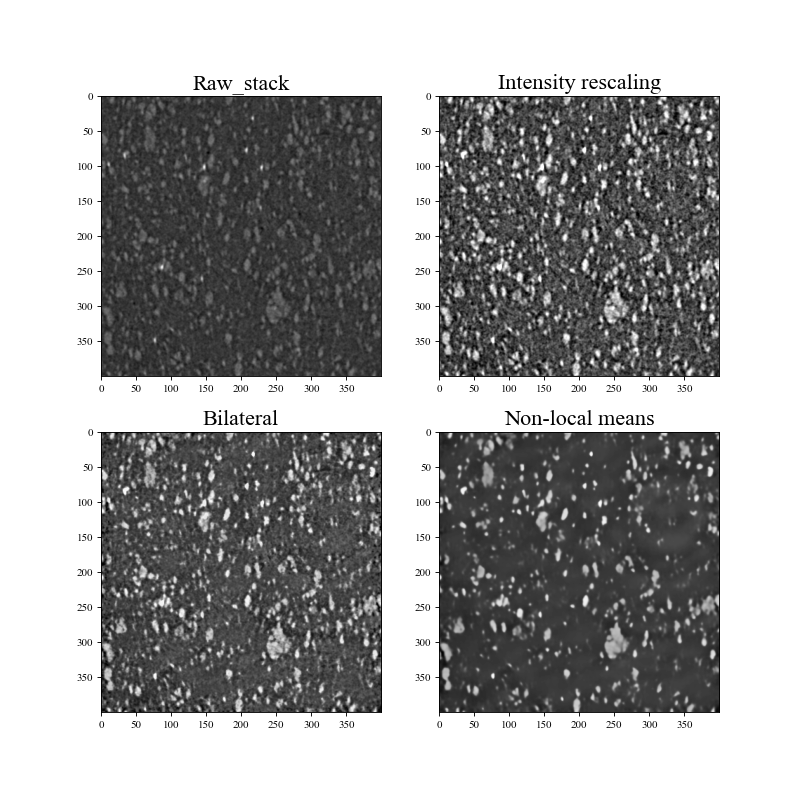

Text(0.5, 1.0, 'Non-local means')

In [72]:
#to show the images
fig, ax =plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(Stack_3d[210,200:600,200:600], cmap='gray')
ax[0,1].imshow(Stack[10], cmap='gray',)
ax[1,0].imshow(bilateral[10], cmap='gray',)
ax[1,1].imshow(nlm[10], cmap='gray',)
ax[0,0].set_title('Raw_stack',fontsize=20)
ax[0,1].set_title('Intensity rescaling',fontsize=20)
ax[1,0].set_title('Bilateral',fontsize=20)
ax[1,1].set_title('Non-local means',fontsize=20)

<font size="4">
An alternative to non local means is total variation filter, 

In [71]:
%%time
tv = restoration.denoise_tv_chambolle(bilateral,weight=.1,eps=0.00001,n_iter_max=500,)

<font size="4">
  
**weight=0.1** *# Denoising weight. The greater weight, the more denoising (at the expense of fidelity to input).*<br/>
    
**epsfloat=0.00001** * #Relative difference of the value of the cost function that determines the stop criterion. The algorithm stops when:*<br/>
    
$(E_{n-1} - E_n) < eps * E_0$
    
<br/>

<IPython.core.display.Javascript object>


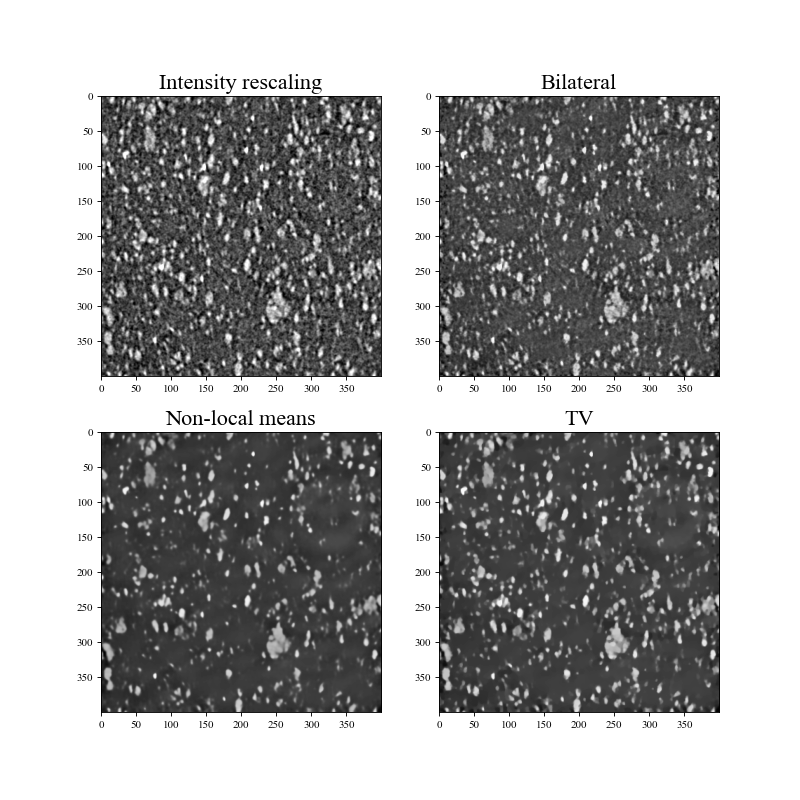

Text(0.5, 1.0, 'TV')

In [70]:
#to show the images
fig, ax =plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(Stack[10], cmap='gray')
ax[0,1].imshow(bilateral[10], cmap='gray',)
ax[1,0].imshow(nlm[10], cmap='gray',)
ax[1,1].imshow(tv[10], cmap='gray',)
ax[0,0].set_title('Intensity rescaling',fontsize=20)
ax[0,1].set_title('Bilateral',fontsize=20)
ax[1,0].set_title('Non-local means',fontsize=20)
ax[1,1].set_title('TV',fontsize=20)

## Random Walker segmentation<br>

<font size="4">
Now we use the random walker algorithm, that will let the markers diffuse inside the nlm image, diffusion being more difficult in regions in high gradients (so that it will be difficult for a marker of one the two phases to cross a boundary to diffuse into the other phase). The parameter beta controls the amount by which gradients are penalized.<br>

To do so, we first create an array of markers, corresponding here to pixels for which the gray value is enough to attribute them to one of the phases, that is with gray values on the two sides of the histogram (mid-range values are still undetermined).<br><br>

<IPython.core.display.Javascript object>


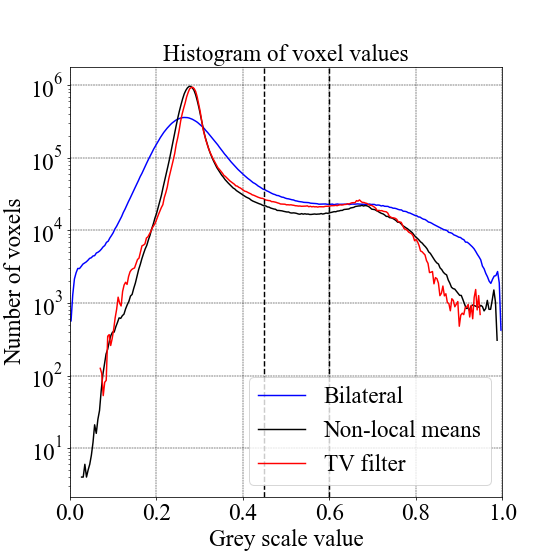

In [135]:
from skimage import exposure

histogram_bilateral = exposure.histogram(bilateral)# to get the histogram of grey scale values
histogram_nlm = exposure.histogram(nlm)# to get the histogram of grey scale values
histogram_tv = exposure.histogram(tv)# to get the histogram of grey scale values

fig, ax=plt.subplots(figsize=(8,8))
ax.plot(histogram_bilateral[1],histogram_bilateral[0], label='Bilateral', color = 'b')
ax.plot(histogram_nlm[1],histogram_nlm[0], label='Non-local means', color = 'k')
ax.plot(histogram_tv [1],histogram_tv [0], label='TV filter', color = 'r')

# parameters for the plot
plt.rcParams["legend.shadow"]= "False"
plt.rcParams["legend.facecolor"]="w"
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = ['Times New Roman']
ax.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 24)
ax.set(xlim=(0,1))
plt.grid(color='black', linestyle='--', linewidth=0.5,visible=True)
plt.xlabel('Grey scale value', fontsize=24,multialignment='center')
plt.ylabel('Number of voxels', fontsize=24,multialignment='center')
plt.rcParams["legend.facecolor"]="white"
plt.legend(fontsize=24)
plt.yscale('log')
plt.title('Histogram of voxel values',fontsize=24,multialignment='center')
plt.axvline(0.45, color='k', ls='--')
plt.axvline(0.6, color='k', ls='--')



<font size="4">
The two vertical lines gives the lower and upper limit of the grey scale values.
A stack image of marker is creates using this limits

In [127]:
markers = np.zeros(nlm.shape, dtype=np.uint8)
markers[nlm > .6] = 1 # upper limit belonging to CB agglomerates
markers[nlm< .45] = 2 # lower limit belonging to matrix

<font size="4">
One can visulize the marker as shown in the image<br/>

<IPython.core.display.Javascript object>


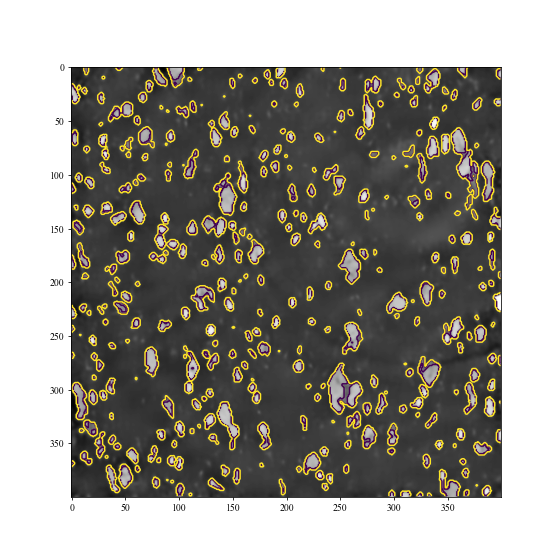

In [124]:
fig, ax=plt.subplots(figsize=(8,8))
plt.imshow(nlm[1], cmap='gray')
plt.contour(markers[1], [0.5, 1.5])

## Code for random walker segmentation

In [128]:
rw = segmentation.random_walker(nlm[0:10], markers[0:10], beta=1000., mode='cg_mg')

C:\Anaconda3-5.1.0\envs\jesbeer\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


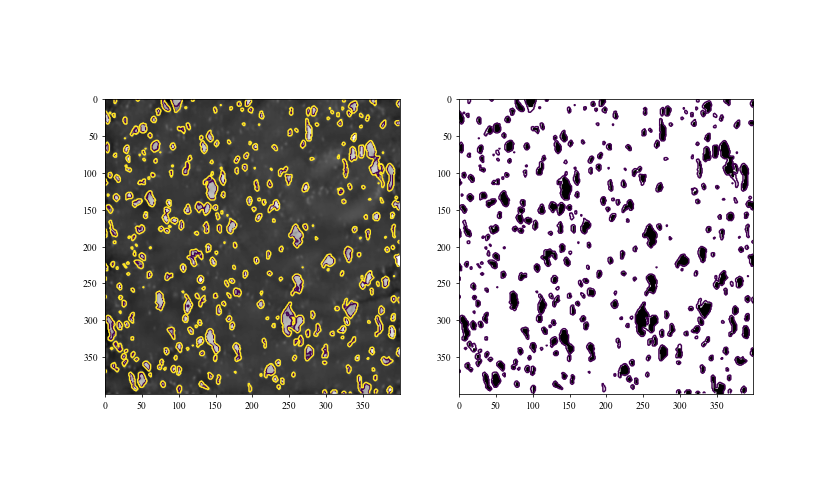

In [129]:
fig, ax=plt.subplots(1,2, figsize=(12,7))
ax[0].imshow(nlm[1], cmap='gray')
ax[0].contour(markers[1], [0.5, 1.5])
ax[1].imshow(rw[1], cmap='gray')
ax[1].contour(markers[1], [1.5])

<IPython.core.display.Javascript object>


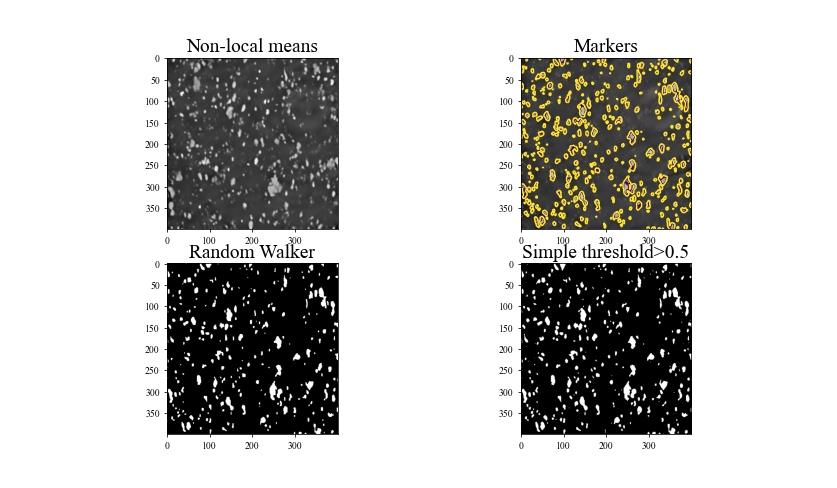

Text(0.5, 1.0, 'Simple threshold>0.5')

In [163]:
#to show the images
fig, ax =plt.subplots(2,2, figsize=(12,7))
ax[0,0].imshow(nlm[10], cmap='gray')
ax[0,1].imshow(nlm[1], cmap='gray')
ax[0,1].contour(markers[1], [0.5, 1.5])
ax[1,0].imshow(rw[1]==1, cmap='gray')
#ax[1,0].contour(markers[1], [1.5])
ax[1,1].imshow(nlm[1]>0.5, cmap='gray')
ax[0,0].set_title('Non-local means',fontsize=20)
ax[0,1].set_title('Markers',fontsize=20)
ax[1,0].set_title('Random Walker',fontsize=20)
ax[1,1].set_title('Simple threshold>0.5',fontsize=20)

In [159]:
clean_segmentation = morphology.remove_small_objects(rw == 1, 8)

<IPython.core.display.Javascript object>


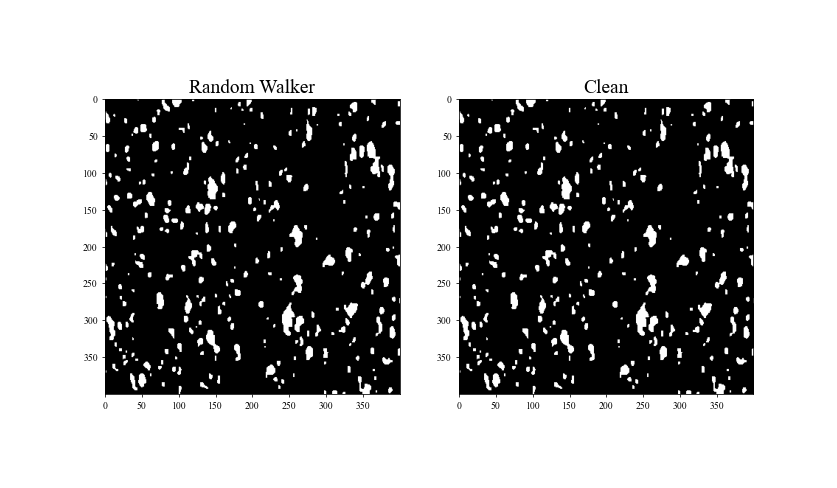

Text(0.5, 1.0, 'Clean')

In [162]:
#to show the images
fig, ax =plt.subplots(1,2, figsize=(12,7))
ax[0].imshow(rw[1]==1, cmap='gray')

ax[1].imshow(clean_segmentation[1], cmap='gray')

ax[0].set_title('Random Walker',fontsize=20)
ax[1].set_title('Clean',fontsize=20)

In [161]:
io.imsave('bilateral.tif',bilateral[:,:,:],plugin='tifffile')
io.imsave('nlm.tif',nlm[:,:,:],plugin='tifffile')
io.imsave('clean.tif',clean_segmentation[:,:,:],plugin='tifffile')

C:\Anaconda3-5.1.0\envs\jesbeer\lib\site-packages\ipykernel_launcher.py:3: UserWarning: clean.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  This is separate from the ipykernel package so we can avoid doing imports until
